## Disclaimer : 

* I am using the cleaned version of the data provided by Chris Deotte, which can be downloaded from[ here](https://www.kaggle.com/cdeotte/data-without-drift).
* Architecture of the model is inspired/borrowed from [xhlulu](https://www.kaggle.com/xhlulu), which can be found [here](https://www.kaggle.com/xhlulu/ion-switching-simple-bi-gru).
* I am new to Kaggle competitions. Therefore, please let me know if I am not following any recommended best practices. I look forward to your constructive criticism. 

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from imblearn import under_sampling
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

In [63]:
train = pd.read_csv("../input/datawithoutdrift/train_clean.csv",index_col=['time'])
test = pd.read_csv("../input/datawithoutdrift/test_clean.csv",index_col=['time'])
submission = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv", dtype=dict(time=str))

In [64]:
len(train), len(test)

(5000000, 2000000)

# Plot settings

In [65]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Class Counts in Training Data')

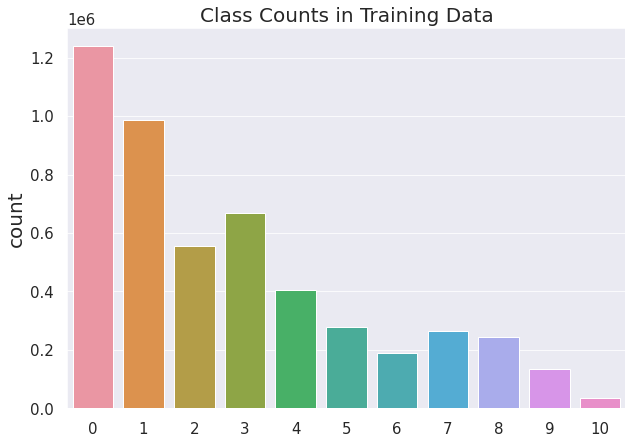

In [67]:
plt.figure(figsize=(10,7))
sns.countplot(train.open_channels.values)
plt.title('Class Counts in Training Data',size=20)

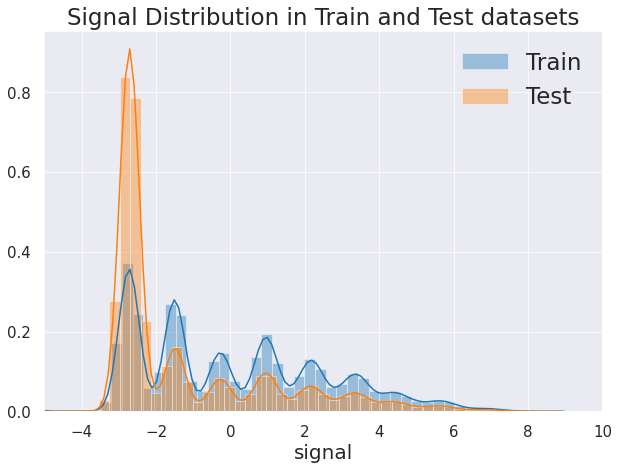

In [68]:
plt.figure(figsize=(10,7))
sns.distplot(train.signal)
sns.distplot(test.signal)
plt.xlim([-5,10])
plt.title('Signal Distribution in Train and Test datasets',size=23)
plt.legend(['Train','Test'],frameon=False)

As lot of us might have seen the signal and open_channels data shares a very strong correlation after removing the drift. I noted that pearson correlation cofficient increase from `0.81` to `0.96` after removing the data. 

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5, 1.0, 'Signal vs Open Channels')

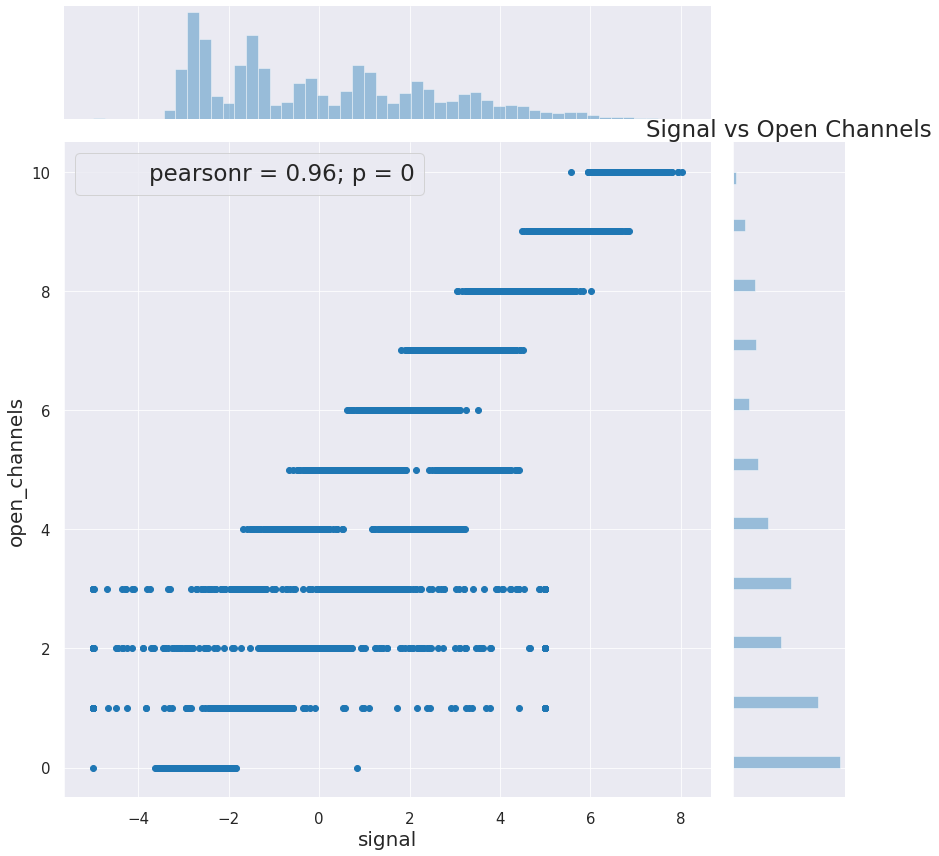

In [69]:
g=sns.jointplot(x='signal', y='open_channels' ,data=train[::100], height=12)
g.annotate(stats.pearsonr)
plt.title('Signal vs Open Channels',size=23)

# Pearson Correlation in the various batches 

In [70]:
def BATCH_CORRELATION(df):
    return stats.pearsonr(df.values[:,0], df.values[:,1])[0]

In [71]:
STEP_SIZE=500000
sp=np.arange(0, len(train),STEP_SIZE)
correlation=[BATCH_CORRELATION(train.iloc[s:(s+STEP_SIZE)]) for s in sp]
batches=['Batch {}'.format(i) for i in range(1,11)]
batch_correlations=dict(zip(batches,correlation))

* There is a very strong correlation in every batch of the data except Batch 1 and Batch 2 (i.e. first 1000,000 lines of data)

(-1.0, 10.0)

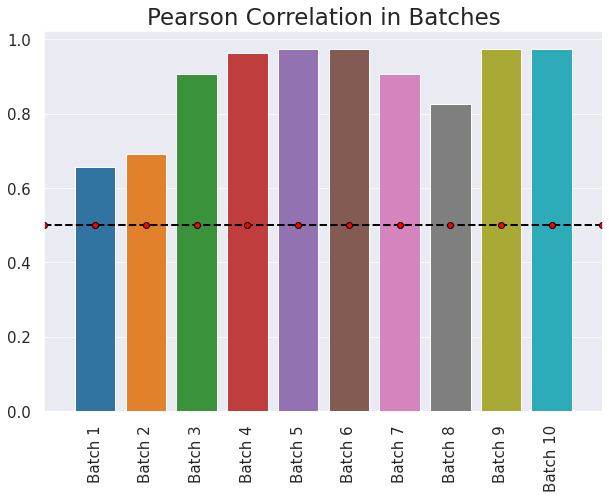

In [72]:
plt.figure(figsize=(10,7))
sns.barplot(data=pd.DataFrame(batch_correlations, index=range(0,10)))
plt.xticks(rotation=90)
plt.title('Pearson Correlation in Batches',size=23)
xx=np.arange(-1,11)
yy=xx*0 + 0.5
plt.plot(xx,yy, lw=2, ls='--', color='k', marker='o', markerfacecolor='r')
plt.xlim(-1,10)

In [86]:
X_res = train.signal.values
y_res = train.open_channels.values

# Undersampling using TomekLinks

* I did some experimentation with the sampling strategy. `samplings_strategy='auto'` gives me the best results. 
* According to the documentation [here](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#tomek-links) :  `sampling_strategy='auto'` removes the samples from the majority class.

In [74]:
sm = under_sampling.TomekLinks(sampling_strategy='auto')
X_res, y_res = sm.fit_resample(train.signal.values.reshape(-1,1), train.open_channels.values.ravel())

In [75]:
X_res=X_res[318:]
y_res=y_res[318:]

In [76]:
X_res.shape ,y_res.shape

((4690000, 1), (4690000,))

In [87]:
seq_len = 1000

X_res = X_res.reshape(-1, seq_len, 1)
y_res = y_res.reshape(-1, seq_len, 1)

* **I reduced the test size to 0.1 to improve training on minority classes.**

In [88]:
X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.1)
X_test= test.signal.values.reshape(-1, seq_len, 1)

Text(0.5, 1.0, 'Class Counts in validation Data')

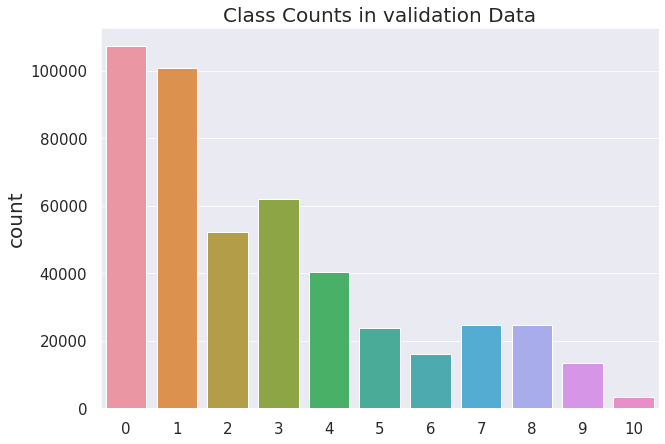

In [79]:
plt.figure(figsize=(10,7))
sns.countplot(y_valid.reshape(-1))
plt.title('Class Counts in validation Data',size=20)

# Creating a Bi-LSTM Model

* ## **With undersampling**

In [80]:
n_units=256
batch=128
n_classes=len(train.open_channels.unique())
inputs = layers.Input(shape=(seq_len, X_train.shape[2]))
outputs = layers.Dense(n_units, activation='linear')(inputs)    
outputs= layers.Bidirectional(layers.LSTM(n_units, return_sequences=True))(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs= layers.Bidirectional(layers.LSTM(n_units, return_sequences=True))(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.Bidirectional(layers.LSTM(n_units, return_sequences=True))(outputs)
outputs = layers.Dense(n_classes, activation='softmax')(outputs)  
model = Model(inputs=inputs, outputs=outputs)
model.compile('adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, 
          batch_size=batch,
          epochs=30,
          callbacks=[ callbacks.ReduceLROnPlateau(), 
                      callbacks.ModelCheckpoint('BiLSTM-N{}-D0.5-B{}+undersampling.h5'.format(n_units,batch)),
                      callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                      callbacks.CSVLogger(f"BiLSTM-log-Nodes-{n_units}-dropout-0.5-batchsize-{batch}+undersampling.csv")],
                      validation_data=(X_valid, y_valid)
                      #class_weight=generate_sample_weights(y_train, class_weight)
                      )

Train on 4221 samples, validate on 469 samples
Epoch 1/30
4221/4221 [==============================] - 40s 9ms/sample - loss: 1.0028 - accuracy: 0.6099 - val_loss: 0.6848 - val_accuracy: 0.7140
Epoch 2/30
4221/4221 [==============================] - 32s 7ms/sample - loss: 0.5905 - accuracy: 0.7525 - val_loss: 0.5294 - val_accuracy: 0.7782
Epoch 3/30
4221/4221 [==============================] - 32s 7ms/sample - loss: 0.5215 - accuracy: 0.7855 - val_loss: 0.4300 - val_accuracy: 0.8271
Epoch 4/30
4221/4221 [==============================] - 32s 7ms/sample - loss: 0.3078 - accuracy: 0.8833 - val_loss: 0.1850 - val_accuracy: 0.9412
Epoch 5/30
4221/4221 [==============================] - 32s 7ms/sample - loss: 0.1592 - accuracy: 0.9444 - val_loss: 0.1135 - val_accuracy: 0.9619
Epoch 6/30
4221/4221 [==============================] - 32s 7ms/sample - loss: 0.1198 - accuracy: 0.9564 - val_loss: 0.1004 - val_accuracy: 0.9646
Epoch 7/30
4221/4221 [==============================] - 32s 7ms/sample 

* ## **Without Undersampling**

In [89]:
n_units=256
batch=128
n_classes=len(train.open_channels.unique())
inputs = layers.Input(shape=(seq_len, X_train.shape[2]))
outputs = layers.Dense(n_units, activation='linear')(inputs)    
outputs= layers.Bidirectional(layers.LSTM(n_units, return_sequences=True))(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs= layers.Bidirectional(layers.LSTM(n_units, return_sequences=True))(outputs)
outputs = layers.Dropout(0.5)(outputs)
outputs = layers.Bidirectional(layers.LSTM(n_units, return_sequences=True))(outputs)
outputs = layers.Dense(n_classes, activation='softmax')(outputs)  
model = Model(inputs=inputs, outputs=outputs)
model.compile('adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, 
          batch_size=batch,
          epochs=30,
          callbacks=[ callbacks.ReduceLROnPlateau(), 
                      callbacks.ModelCheckpoint('BiLSTM-N{}-D0.5-B{}.h5'.format(n_units,batch)),
                      callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                      callbacks.CSVLogger(f"BiLSTM-log-Nodes-{n_units}-dropout-0.5-batchsize-{batch}.csv")],
                      validation_data=(X_valid, y_valid)
                      #class_weight=generate_sample_weights(y_train, class_weight)
                      )

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 41s 9ms/sample - loss: 1.0781 - accuracy: 0.5771 - val_loss: 0.7160 - val_accuracy: 0.6994
Epoch 2/30
4500/4500 [==============================] - 34s 8ms/sample - loss: 0.6534 - accuracy: 0.7274 - val_loss: 0.5240 - val_accuracy: 0.7788
Epoch 3/30
4500/4500 [==============================] - 34s 8ms/sample - loss: 0.4641 - accuracy: 0.8087 - val_loss: 0.3218 - val_accuracy: 0.8780
Epoch 4/30
4500/4500 [==============================] - 34s 8ms/sample - loss: 0.2806 - accuracy: 0.8948 - val_loss: 0.1436 - val_accuracy: 0.9511
Epoch 5/30
4500/4500 [==============================] - 34s 8ms/sample - loss: 0.1588 - accuracy: 0.9414 - val_loss: 0.1079 - val_accuracy: 0.9613
Epoch 6/30
4500/4500 [==============================] - 34s 8ms/sample - loss: 0.1323 - accuracy: 0.9500 - val_loss: 0.0971 - val_accuracy: 0.9643
Epoch 7/30
4500/4500 [==============================] - 34s 8ms/sample 

# Evaluate Bi-LSTM model without Undersampling

In [90]:
model.load_weights('BiLSTM-N256-D0.5-B128.h5')
valid_pred = model.predict(X_valid, batch_size=128).argmax(axis=-1)
print('Accuracy Score : {}'.format(accuracy_score(y_valid.reshape(-1), valid_pred.reshape(-1))))
print('F1 Score : {}'.format(f1_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))
print('Precision Score : {}'.format(precision_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))
print('Recall Score : {}'.format(recall_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))

Accuracy Score : 0.969872
F1 Score : 0.9385079735266779
Precision Score : 0.9373987518778595
Recall Score : 0.9396668194200064


In [91]:
conf_mat=confusion_matrix(y_valid.reshape(-1), valid_pred.reshape(-1))
_ , counts= np.unique(y_valid, return_counts=True)
normalized_conf_mat = conf_mat/counts

Text(0.5, 1.0, 'Confusion Matrix showing performance for each class without undersampling')

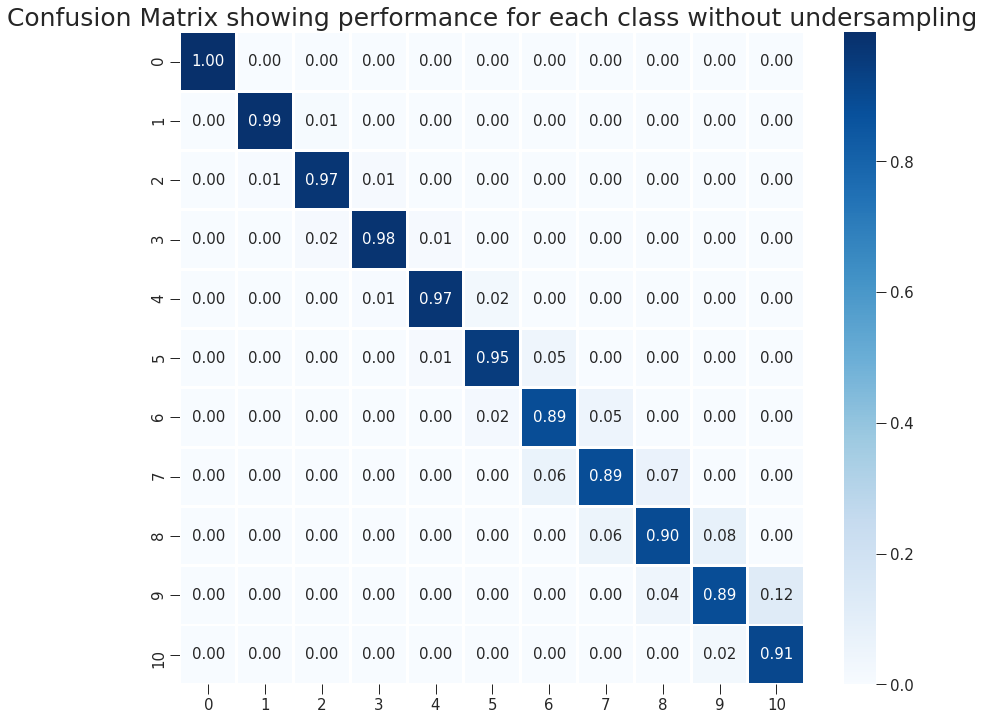

In [92]:
sns.set_style('ticks')
plt.figure(figsize=(14,12))
sns.heatmap(normalized_conf_mat, lw=2, cmap='Blues', annot=True, fmt='.2f', annot_kws={'size':15} )
plt.title('Confusion Matrix showing performance for each class without undersampling',size=25)

In [93]:
class_performance_without_us = dict(zip(_, np.diagonal(normalized_conf_mat)))
class_performance_without_us=pd.DataFrame(class_performance_without_us, index=range(0,1))

# Evaluate Bi-LSTM model with Undersampling

In [81]:
model.load_weights('BiLSTM-N256-D0.5-B128+undersampling.h5')
valid_pred = model.predict(X_valid, batch_size=128).argmax(axis=-1)
print('Accuracy Score : {}'.format(accuracy_score(y_valid.reshape(-1), valid_pred.reshape(-1))))
print('F1 Score : {}'.format(f1_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))
print('Precision Score : {}'.format(precision_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))
print('Recall Score : {}'.format(recall_score(y_valid.reshape(-1), valid_pred.reshape(-1), average='macro')))

Accuracy Score : 0.9726695095948827
F1 Score : 0.9441009813425524
Precision Score : 0.9423617641630572
Recall Score : 0.9459572719343883


In [82]:
conf_mat=confusion_matrix(y_valid.reshape(-1), valid_pred.reshape(-1))
_ , counts= np.unique(y_valid, return_counts=True)
normalized_conf_mat = conf_mat/counts

Text(0.5, 1.0, 'Confusion Matrix showing performance for each class with undersampling')

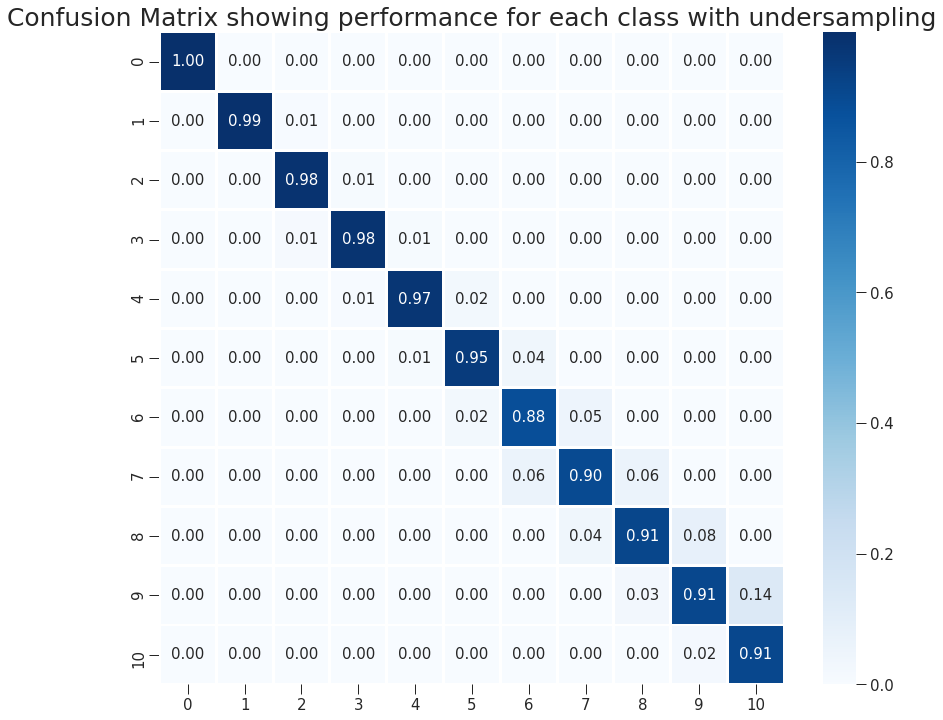

In [83]:
sns.set_style('ticks')
plt.figure(figsize=(14,12))
sns.heatmap(normalized_conf_mat, lw=2, cmap='Blues', annot=True, fmt='.2f', annot_kws={'size':15} )
plt.title('Confusion Matrix showing performance for each class with undersampling',size=25)

In [84]:
class_performance_with_us = dict(zip(_, np.diagonal(normalized_conf_mat)))
class_performance_with_us=pd.DataFrame(class_performance_with_us, index=range(0,1))

In [94]:
class_performance=pd.concat([class_performance_without_us,class_performance_with_us]).T
class_performance.columns=['Without Undersampling','With Undersampling']

In [99]:
class_performance.style.background_gradient()

,Without Undersampling,With Undersampling
0,0.998189,0.998789
1,0.989881,0.993653
2,0.973042,0.983527
3,0.979115,0.982480
4,0.972628,0.974330
5,0.950599,0.953874
6,0.888204,0.884921
7,0.887973,0.899492
8,0.896151,0.913548
9,0.888338,0.910087


(0.7, 1.1)

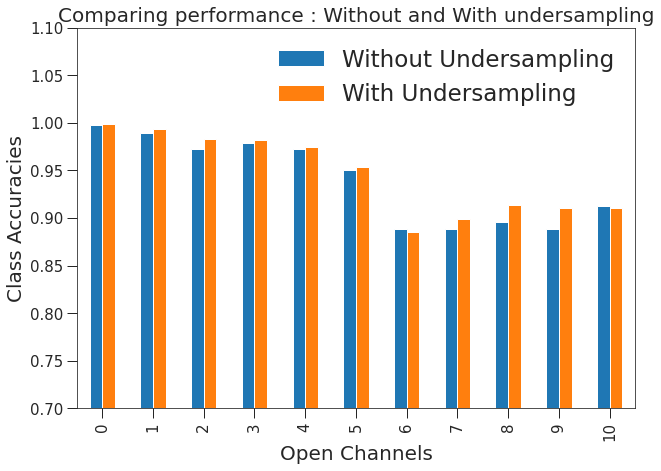

In [100]:
class_performance.plot.bar(figsize=(10,7))
plt.legend(frameon=False, bbox_to_anchor=(1.0,1))
plt.ylabel('Class Accuracies')
plt.xlabel('Open Channels')
plt.title('Comparing performance : Without and With undersampling',size=20)
plt.ylim([0.7,1.1])

# Conclusion 
* From the above plot,  it seems that the undersampling using 'TomekLinks' does improve the performance on individual classes.
* It can be noted that the plot above may not be the best comparision because I reduced the test_size=0.1. However, I noticed that usage of undersampling improves my submission score.

# Generating the submission csv

In [103]:
model=load_model('BiLSTM-N256-D0.5-B128+undersampling.h5')
test_pred = model.predict(X_test, batch_size=128).argmax(axis=-1)
submission.open_channels = test_pred.reshape(-1)
submission.to_csv('submission.csv', index=False)